# Task 2 - sarcastic JSON 

Enclosed dataset contains data about press headlines – their content and type. Aim of this task is to create binary classification model for headline type (sarcastic / not sarcastic) based on headline content.

**Goal:** Based on attached data build a model that will classify headline types.

## Before I start ...

The task is to classify whether the headline is sarcastic based solely on its content. 

The definition of **sarcasm** according to the Cambridge Dictionary is: 
> "the use of remarks that clearly mean the opposite of what they say, made in order to hurt someone's feelings or to criticize something in a humorous way"

Other definitions point out that usually it is used in **speech**. Detection of sarcasm in writing can sometimes pose a challenge even to a human. Often headlines are accompanied by photos or graphics that help a reader detect the sarcastic tone in the headline. It is very contextual and pre-trained sentiment or emotion classifier can be extremely helpful in that scenario. 

Some labels can be mistakenly assigned. There might be some false negatives: sarcastic comments work perfectly when they are tailored to the person and specific situation. Machine learning models would need to have a high level of world knowledge to classify everything correctly. So some headlines might not be picked up by the model

## Set up all the packages and paths

In [1]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
import os

In [2]:
file = os.getcwd() + r"/Datasets/Graduate - HEADLINES dataset (2019-06).json"
print(file)

/home/mab/Code4Life_MAB/Datasets/Graduate - HEADLINES dataset (2019-06).json


## Combine all the JSON documents into a pandas dataframe

The original file looks like that:
```
{"headline": "former versace store clerk sues over secret 'black code' for minority shoppers", 
"is_sarcastic": 0}
{"headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", 
"is_sarcastic": 0}
...
```
I am going to transform it into a more convenient format

In [3]:
df = pd.read_json(file, lines = True)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## Exploratory Data Analysis

In [4]:
print(df.describe())
print(df.count())

       is_sarcastic
count  26709.000000
mean       0.438953
std        0.496269
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
headline        26709
is_sarcastic    26709
dtype: int64


The dataset consists of 26 709 records. Mean of 0.44 indicates that the classes are almost evenly represented so we don't have to counter the effect of unbalanced data. There are no missing values in either column.

## Natual Language Processing

1. Data cleaning - removing special characters and digits if they don't provide valuable information
2. Changing every word to lower case (already done)
3. Removing stopwords
4. Stemming / lemmatizing

### Data cleaning

It's important to remove special characters if they don't hold any valuable information about whether the headline is sarcastic or not. 

The next step is **stemming** - converting a word into its root form (e.g. playing --> play)


In [5]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces, #just in case there are any
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.stem_text # Porter Stemmer algorithm
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [6]:
df['clean_headline'] = df['headline'].apply(lambda x: clean_text(x))
print(df['headline'][3])
print(df['clean_headline'][3])

boehner just wants wife to listen, not come up with alternative debt-reduction ideas
boehner want wife listen come altern debt reduct idea


Stemming the original text made the words more "standard" for a computer. However, they can still be understood by a human reader even though they are not a 100% correct English words all the time

### Wordcloud of words in sarcastic headlines (left) and those non-sarcastic (right)

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# import nltk
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))

In [8]:
def create_wordcloud(sarcastic, background = 'white'):
    
    wordlist = df['clean_headline'][df['is_sarcastic'] == sarcastic].tolist()
    lstring = ' '.join(wordlist)

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = background, 
                    random_state = 42, 
                    min_font_size = 10).generate(lstring) 
    return wordcloud

wordcloud_s = create_wordcloud(sarcastic = True, background = 'black')
wordcloud_ns = create_wordcloud(sarcastic = False)

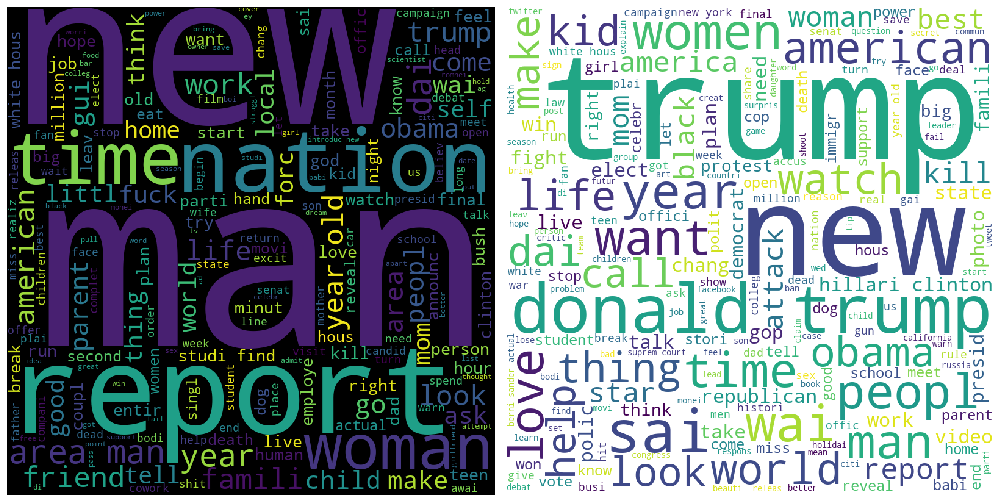

In [9]:
plt.figure(figsize = (14, 8), facecolor = None) 

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_s) 
plt.axis("off")  

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ns) 
plt.axis("off")

plt.tight_layout()    
 
plt.show() 

# Beginning of models

In [11]:
df_x = df['clean_headline']
df_y = df['is_sarcastic']

In [12]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm
import multiprocess

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocess.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [13]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 26709/26709 [00:00<00:00, 3066172.15it/s]


matrix([[-1.5095608e-04,  1.0302041e-03,  1.1999792e-03, ...,
         -1.5702004e-03, -2.4864804e-03, -2.3803764e-03],
        [-4.3010507e-03,  1.3295360e-04, -4.0278500e-03, ...,
          1.5123976e-04,  2.1229584e-03, -4.4426825e-03],
        [-2.6894468e-03, -1.6328783e-03, -2.1730298e-03, ...,
          2.5335038e-03,  4.4026203e-03,  1.0168529e-03],
        ...,
        [ 2.1510512e-02,  1.2269143e-01, -6.6524923e-02, ...,
         -1.0864553e+00,  4.4820544e-01,  5.5001462e-01],
        [ 3.6082575e-03, -1.3710411e-03,  3.1807169e-03, ...,
         -3.0178248e-03, -4.4352168e-04, -2.9314305e-03],
        [ 3.2088157e-02,  7.9935081e-02, -5.0492395e-02, ...,
         -5.4530054e-01,  2.3195717e-01,  3.2507879e-01]], dtype=float32)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='ovr', 
                                                            solver='saga', 
                                                            max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5, scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 21367/21367 [00:00<00:00, 4809213.50it/s]
/home/mab/.local/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 21367/21367 [00:00<00:00, 4857172.70it/s]
/home/mab/.local/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 21367/21367 [00:00<00:00, 4048594.76it/s]
/home/mab/.local/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 21367/21367 [00:00<00:00, 4549915.90it/s]


KeyboardInterrupt: 

In [15]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 21367/21367 [00:00<00:00, 4650977.92it/s]


KeyboardInterrupt: 

In [20]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='reg:logistic'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 21367/21367 [00:00<00:00, 4300781.92it/s]


KeyboardInterrupt: 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [18]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [19]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='ovr', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.7861393158790622


In [ ]:

pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

In [ ]:

pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='reg:logistic'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

# End of models

In [26]:
## Number of words in the text
df["num_words"] = df["headline"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text
df["num_unique_words"] =  df["headline"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text
df["num_chars"] =  df["headline"].apply(lambda x: len(str(x)))

## Number of stopwords in the text
df["num_stopwords"] = df["headline"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Average length of the words in the text
df["mean_word_len"] =  df["headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

df.head()

,headline,is_sarcastic,num_words,num_unique_words,num_chars,num_stopwords,mean_word_len
0,former versace store clerk sues over secret 'b...,0,12,12,78,2,5.583333
1,the 'roseanne' revival catches up to our thorn...,0,14,14,84,6,5.071429
2,mom starting to fear son's web series closest ...,1,14,13,79,5,4.714286
3,"boehner just wants wife to listen, not come up...",1,13,13,84,5,5.538462
4,j.k. rowling wishes snape happy birthday in th...,0,11,11,64,3,4.909091
